## 데이터 가져오기

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchtext==0.3.1

In [3]:
import re
import sys
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchtext import data
from torchtext import datasets

import numpy as np 

In [4]:
#  Seed 고정
def torch_seed(random_seed=42):

    torch.manual_seed(random_seed)

    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)

torch_seed()

In [5]:
!pip install transformers

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base")

In [7]:
TEXT = data.Field(batch_first = True, 
                  fix_length = 200, 
                  tokenize=tokenizer.tokenize, 
                  pad_first=True, 
                  pad_token='[PAD]', 
                  unk_token='[UNK]')
LABEL = data.LabelField(dtype=torch.float)

train_data = data.TabularDataset(path='/content/drive/MyDrive/train_review.csv', 
                    format='csv', 
                    fields=[("text",TEXT),
                            ("label",LABEL)],  
                    skip_header=True)

test_data = data.TabularDataset(path='/content/drive/MyDrive/test_review.csv', 
                    format='csv', 
                    fields=[("text",TEXT),
                            ("label",LABEL)],  
                    skip_header=True)

In [8]:
print(f'Train Data Length : {len(train_data.examples)}')  # 데이터의 개수를 확인
print(f'Test Data Length : {len(test_data.examples)}')

Train Data Length : 50000
Test Data Length : 15000


In [9]:
print('---- Data Sample ----')
print('Input : ')
print(' '.join(vars(train_data.examples[0])['text']),'\n')  # vars() : 데이터의 값을 직접 확인
print('Label : ')
print(vars(train_data.examples[1])['label'])  

---- Data Sample ----
Input : 
절대 ##가지 ##마세요 몸 다 상 ##합니다 부서 절대 ##요 

Label : 
0


## 데이터 전처리

In [10]:
def PreProcessingText(input_sentence):
    input_sentence = input_sentence.lower() # 소문자화
    input_sentence = re.sub('<[^>]*>', repl= ' ', string = input_sentence) # "<br />" 처리
    input_sentence = re.sub('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]', repl= ' ', string = input_sentence) # 특수문자 처리 ("'" 제외)
    input_sentence = re.sub('\s+', repl= ' ', string = input_sentence) # 연속된 띄어쓰기 처리
    return input_sentence

In [11]:
# 간단한 Data Cleansing 작업
for example in train_data.examples:
    vars(example)['text'] = PreProcessingText(' '.join(vars(example)['text'])).split()
    
for example in test_data.examples:
    vars(example)['text'] = PreProcessingText(' '.join(vars(example)['text'])).split()

## 임베딩

In [12]:
model_config = {'emb_type' : '', 'emb_dim' : 300}

In [13]:
# build_vocab() : Text Data와 Label Data의 Vocab을 만듦
TEXT.build_vocab(train_data,  
                 min_freq = 1,  # vocab에 해당하는 token에 최소한으로 등장하는 횟수 
                 max_size = None,  # 전체 vocab size 자체에 제한
                 vectors = f"glove.6B.{model_config['emb_dim']}d")  # pre-trained vector

LABEL.build_vocab(train_data)

model_config['vocab_size'] = len(TEXT.vocab) 

In [14]:
# Vocabulary Info
print(f'Vocab Size : {len(TEXT.vocab)}')

print('Vocab Examples : ')
for idx, (k, v) in enumerate(TEXT.vocab.stoi.items()):
    if idx >= 10:  # 상위 10개 Vacab의 단어와 index 값을 가져옴
        break    
    print('\t', k, v)

print('---------------------------------')

# Label Info
print(f'Label Size : {len(LABEL.vocab)}')

print('Lable Examples : ')
for idx, (k, v) in enumerate(LABEL.vocab.stoi.items()):
    print('\t', k, v)

Vocab Size : 17394
Vocab Examples : 
	 [UNK] 0
	 [PAD] 1
	 회사 2
	 이 3
	 가 4
	 는 5
	 을 6
	 수 7
	 에 8
	 의 9
---------------------------------
Label Size : 2
Lable Examples : 
	 0 0
	 1 1


## 데이터셋 분리

In [15]:
train_data, valid_data = train_data.split(random_state = random.seed(0), split_ratio=0.8)

In [16]:
model_config['batch_size'] = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(datasets=(train_data, valid_data, test_data), 
                                                                           batch_size=model_config['batch_size'], device=device, sort=False)

## Sample Data

In [17]:
# Check batch data
sample_for_check = next(iter(train_iterator))  # 돌아가지 않을 경우 torchtext 버전이 0.3.1 버전이 맞는지 확인
print(sample_for_check)
print(sample_for_check.text)
print(sample_for_check.label)


[torchtext.data.batch.Batch of size 64]
	[.text]:[torch.cuda.LongTensor of size 64x200 (GPU 0)]
	[.label]:[torch.cuda.FloatTensor of size 64 (GPU 0)]
tensor([[   1,    1,    1,  ...,  458,  869,  306],
        [   1,    1,    1,  ...,  974,    5,   92],
        [   1,    1,    1,  ..., 5843, 1780,  572],
        ...,
        [   1,    1,    1,  ...,   66,  145,   37],
        [   1,    1,    1,  ...,  473,   12, 2816],
        [   1,    1,    1,  ...,   16, 1506,   13]], device='cuda:0')
tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 1.], device='cuda:0')


In [18]:
print(' '.join([TEXT.vocab.itos[int(x)] for x in sample_for_check.text[0,:] if x not in [0,1]]))
print(LABEL.vocab.itos[int(sample_for_check.label[0])]) 

한화 로 매각 진행 중이 므로 미래 불안 정
0


## Modeling

In [19]:
class SentenceClassification(nn.Module):
    def __init__(self, **model_config):
        super(SentenceClassification, self).__init__()

        if model_config['emb_type'] == 'glove' or 'fasttext':  
            self.emb = nn.Embedding(num_embeddings = model_config['vocab_size'],  
                                    embedding_dim = model_config['emb_dim'],  #
                                    _weight = TEXT.vocab.vectors) 
                                                                 
        else:
            self.emb = nn.Embedding(num_embeddings = model_config['vocab_size'],
                                    embedding_dim = model_config['emb_dim'])
        
        self.model_type =  model_config['model_type']
        self.bidirectional = model_config['bidirectional'] 
        self.num_direction = 2 if model_config['bidirectional'] else 1
        self.model_type = model_config['model_type'] 
        self.num_layers = model_config['num_layers']

        self.RNN = nn.RNN (input_size = model_config['emb_dim'],  
                           hidden_size = model_config['hidden_dim'],  
                           dropout = model_config['dropout'],
                           nonlinearity = 'tanh',
                           num_layers = model_config['num_layers'],  
                           bidirectional = model_config['bidirectional'], 
                           batch_first = model_config['batch_first'])
         
        self.LSTM = nn.LSTM(input_size = model_config['emb_dim'], 
                            hidden_size = model_config['hidden_dim'], 
                            dropout = model_config['dropout'], 
                            bidirectional = model_config['bidirectional'],
                            num_layers = model_config['num_layers'], 
                            batch_first = model_config['batch_first'])

        self.GRU = nn.GRU(input_size = model_config['emb_dim'], 
                          hidden_size = model_config['hidden_dim'], 
                          dropout = model_config['dropout'], 
                          bidirectional = model_config['bidirectional'],
                          num_layers = model_config['num_layers'], 
                          batch_first = model_config['batch_first'])
    
        self.fc = nn.Linear(model_config['hidden_dim'] * self.num_direction, model_config['output_dim'])
        
        self.drop = nn.Dropout(model_config['dropout'])

    def forward(self, x):
        emb = self.drop(self.emb(x))

        if self.model_type == 'RNN':
          out, h = self.RNN(emb) 
          last_output = out[:,-1,:]
        elif self.model_type == 'LSTM':
          out, (h, c) = self.LSTM(emb)
          last_output = out[:,-1,:]
        elif self.model_type == 'GRU':
          out, h = self.GRU(emb)
          last_output = out[:,-1,:]

        return self.fc(self.drop(last_output))

In [20]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum()/len(correct)
    return acc

### Training

In [21]:
def train(model, iterator, optimizer, loss_fn, idx_epoch, **model_params):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train() 
    batch_size = model_params['batch_size']

    for idx, batch in enumerate(iterator):
        
        # Initializing
        optimizer.zero_grad()
        
        # Forward 
        predictions = model(batch.text).squeeze()
        loss = loss_fn(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        sys.stdout.write(
                    "\r" + f"[Train] Epoch : {idx_epoch:^3}"\
                    f"[{(idx + 1) * batch_size} / {len(iterator) * batch_size} ({100. * (idx + 1) / len(iterator) :.4}%)]"\
                    f"  Loss: {loss.item():.4}"\
                    f"  Acc : {acc.item():.4}")

        # Backward 
        loss.backward()
        optimizer.step()
        
        # Update Epoch Performance
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss/len(iterator) , epoch_acc/len(iterator) 

In [22]:
def evaluate(model, iterator, loss_fn):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = loss_fn(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### GRU

In [23]:
model_config.update(dict(batch_first = True,
                         model_type = '',
                         bidirectional = True,
                         num_layers = 2,
                         hidden_dim = 128,
                         output_dim = 1,
                         dropout = 0))

In [24]:
model_config['model_type'] = 'GRU'
model_gru = SentenceClassification(**model_config).to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr = 0.003)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [25]:
N_EPOCH = 5

train_loss_arr = []
valid_loss_arr = []

best_valid_loss = float('inf')
model_name = f"{'bi-' if model_config['bidirectional'] else ''}{model_config['model_type']}_{model_config['emb_type']}"

print('---------------------------------')
print(f'Model name : {model_name}')
print('---------------------------------')

for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model_gru, train_iterator, optimizer, loss_fn, epoch, **model_config)
    valid_loss, valid_acc = evaluate(model_gru, valid_iterator, loss_fn)
    train_loss_arr.append(train_loss)
    valid_loss_arr.append(valid_loss)
    print('')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_gru.state_dict(), f'./{model_name}.pt')
        print(f'\t Saved at {epoch}-epoch')

    print(f'\t Epoch : {epoch} | Train Loss : {train_loss:.4} | Train Acc : {train_acc:.4}')
    print(f'\t Epoch : {epoch} | Valid Loss : {valid_loss:.4} | Valid Acc : {valid_acc:.4}')

---------------------------------
Model name : bi-GRU_
---------------------------------
[Train] Epoch :  0 [40000 / 40000 (100.0%)]  Loss: 0.3944  Acc : 0.8438
	 Saved at 0-epoch
	 Epoch : 0 | Train Loss : 0.4682 | Train Acc : 0.7798
	 Epoch : 0 | Valid Loss : 0.4198 | Valid Acc : 0.8105
[Train] Epoch :  1 [40000 / 40000 (100.0%)]  Loss: 0.3694  Acc : 0.8125
	 Epoch : 1 | Train Loss : 0.3397 | Train Acc : 0.8549
	 Epoch : 1 | Valid Loss : 0.4688 | Valid Acc : 0.8049
[Train] Epoch :  2 [40000 / 40000 (100.0%)]  Loss: 0.3531  Acc : 0.8438
	 Epoch : 2 | Train Loss : 0.2586 | Train Acc : 0.8943
	 Epoch : 2 | Valid Loss : 0.4771 | Valid Acc : 0.7944
[Train] Epoch :  3 [40000 / 40000 (100.0%)]  Loss: 0.2613  Acc : 0.9062
	 Epoch : 3 | Train Loss : 0.1904 | Train Acc : 0.9228
	 Epoch : 3 | Valid Loss : 0.6018 | Valid Acc : 0.7901
[Train] Epoch :  4 [40000 / 40000 (100.0%)]  Loss: 0.09248  Acc : 0.9844
	 Epoch : 4 | Train Loss : 0.1444 | Train Acc : 0.9427
	 Epoch : 4 | Valid Loss : 0.7079 | 

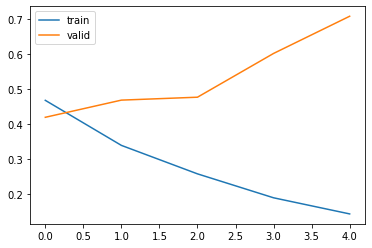

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

In [27]:
# Test set
model_gru.load_state_dict(torch.load(f'./{model_name}.pt'))
test_loss, test_acc = evaluate(model_gru, test_iterator, loss_fn)
print(f'Test Loss : {test_loss:.4} | Test Acc : {test_acc:.4}')

Test Loss : 0.4314 | Test Acc : 0.806


### bi-RNN

In [28]:
model_config.update(dict(batch_first = True,
                         model_type = '',
                         bidirectional = True,
                         num_layers = 2,
                         hidden_dim = 128,
                         output_dim = 1,
                         dropout = 0))

In [29]:
model_config['model_type'] = 'RNN'
model_rnn = SentenceClassification(**model_config).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr = 0.003)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [30]:
N_EPOCH = 5

train_loss_arr = []
valid_loss_arr = []

best_valid_loss = float('inf')
model_name = f"{'bi-' if model_config['bidirectional'] else ''}{model_config['model_type']}_{model_config['emb_type']}"

print('---------------------------------')
print(f'Model name : {model_name}')
print('---------------------------------')

for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model_rnn, train_iterator, optimizer, loss_fn, epoch, **model_config)
    valid_loss, valid_acc = evaluate(model_rnn, valid_iterator, loss_fn)
    train_loss_arr.append(train_loss)
    valid_loss_arr.append(valid_loss)
    print('')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_rnn.state_dict(), f'./{model_name}.pt')
        print(f'\t Saved at {epoch}-epoch')

    print(f'\t Epoch : {epoch} | Train Loss : {train_loss:.4} | Train Acc : {train_acc:.4}')
    print(f'\t Epoch : {epoch} | Valid Loss : {valid_loss:.4} | Valid Acc : {valid_acc:.4}')

---------------------------------
Model name : bi-RNN_
---------------------------------
[Train] Epoch :  0 [40000 / 40000 (100.0%)]  Loss: 0.5484  Acc : 0.7656
	 Saved at 0-epoch
	 Epoch : 0 | Train Loss : 0.5573 | Train Acc : 0.7221
	 Epoch : 0 | Valid Loss : 0.577 | Valid Acc : 0.72
[Train] Epoch :  1 [40000 / 40000 (100.0%)]  Loss: 0.3268  Acc : 0.875
	 Saved at 1-epoch
	 Epoch : 1 | Train Loss : 0.4851 | Train Acc : 0.7769
	 Epoch : 1 | Valid Loss : 0.502 | Valid Acc : 0.7736
[Train] Epoch :  2 [40000 / 40000 (100.0%)]  Loss: 0.418  Acc : 0.8125
	 Epoch : 2 | Train Loss : 0.4198 | Train Acc : 0.8187
	 Epoch : 2 | Valid Loss : 0.512 | Valid Acc : 0.7693
[Train] Epoch :  3 [40000 / 40000 (100.0%)]  Loss: 0.5723  Acc : 0.7188
	 Epoch : 3 | Train Loss : 0.4156 | Train Acc : 0.819
	 Epoch : 3 | Valid Loss : 0.5185 | Valid Acc : 0.7529
[Train] Epoch :  4 [40000 / 40000 (100.0%)]  Loss: 0.5398  Acc : 0.7656
	 Epoch : 4 | Train Loss : 0.3974 | Train Acc : 0.8286
	 Epoch : 4 | Valid Loss :

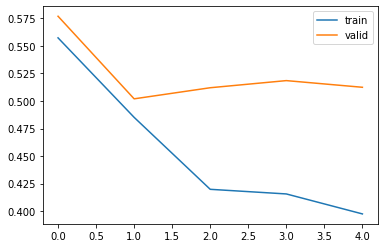

In [31]:
import matplotlib.pyplot as plt

plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

In [32]:
# Test set
model_rnn.load_state_dict(torch.load(f'./{model_name}.pt'))
test_loss, test_acc = evaluate(model_rnn, test_iterator, loss_fn)
print(f'Test Loss : {test_loss:.4} | Test Acc : {test_acc:.4}')

Test Loss : 0.5088 | Test Acc : 0.7676


### LSTM

In [33]:
model_config.update(dict(batch_first = True,
                         model_type = '',
                         bidirectional = True,
                         num_layers = 2,
                         hidden_dim = 128,
                         output_dim = 1,
                         dropout = 0))

In [34]:
model_config['model_type'] = 'LSTM'
model_lstm = SentenceClassification(**model_config).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 0.003)
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [35]:
N_EPOCH = 5

train_loss_arr = []
valid_loss_arr = []

best_valid_loss = float('inf')
model_name = f"{'bi-' if model_config['bidirectional'] else ''}{model_config['model_type']}_{model_config['emb_type']}"

print('---------------------------------')
print(f'Model name : {model_name}')
print('---------------------------------')

for epoch in range(N_EPOCH):
    train_loss, train_acc = train(model_lstm, train_iterator, optimizer, loss_fn, epoch, **model_config)
    valid_loss, valid_acc = evaluate(model_lstm, valid_iterator, loss_fn)
    train_loss_arr.append(train_loss)
    valid_loss_arr.append(valid_loss)
    print('')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_lstm.state_dict(), f'./{model_name}.pt')
        print(f'\t Saved at {epoch}-epoch')

    print(f'\t Epoch : {epoch} | Train Loss : {train_loss:.4} | Train Acc : {train_acc:.4}')
    print(f'\t Epoch : {epoch} | Valid Loss : {valid_loss:.4} | Valid Acc : {valid_acc:.4}')

---------------------------------
Model name : bi-LSTM_
---------------------------------
[Train] Epoch :  0 [40000 / 40000 (100.0%)]  Loss: 0.3893  Acc : 0.8594
	 Saved at 0-epoch
	 Epoch : 0 | Train Loss : 0.4829 | Train Acc : 0.7737
	 Epoch : 0 | Valid Loss : 0.4363 | Valid Acc : 0.8076
[Train] Epoch :  1 [40000 / 40000 (100.0%)]  Loss: 0.4718  Acc : 0.7344
	 Saved at 1-epoch
	 Epoch : 1 | Train Loss : 0.3586 | Train Acc : 0.8454
	 Epoch : 1 | Valid Loss : 0.4275 | Valid Acc : 0.8129
[Train] Epoch :  2 [40000 / 40000 (100.0%)]  Loss: 0.3643  Acc : 0.8594
	 Epoch : 2 | Train Loss : 0.2894 | Train Acc : 0.88
	 Epoch : 2 | Valid Loss : 0.4683 | Valid Acc : 0.7995
[Train] Epoch :  3 [40000 / 40000 (100.0%)]  Loss: 0.3616  Acc : 0.8281
	 Epoch : 3 | Train Loss : 0.2318 | Train Acc : 0.9052
	 Epoch : 3 | Valid Loss : 0.5687 | Valid Acc : 0.7969
[Train] Epoch :  4 [40000 / 40000 (100.0%)]  Loss: 0.3791  Acc : 0.8281
	 Epoch : 4 | Train Loss : 0.1812 | Train Acc : 0.9279
	 Epoch : 4 | Valid

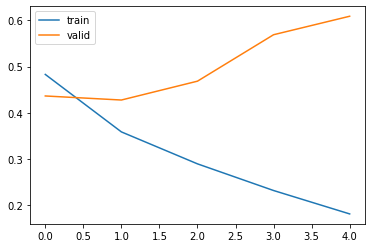

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_loss_arr, label='train')
plt.plot(valid_loss_arr, label='valid')
plt.legend()
plt.show()

In [37]:
# Test set
model_lstm.load_state_dict(torch.load(f'./{model_name}.pt'))
test_loss, test_acc = evaluate(model_lstm, test_iterator, loss_fn)
print(f'Test Loss : {test_loss:.4} | Test Acc : {test_acc:.4}')

Test Loss : 0.4394 | Test Acc : 0.8045
